Инициализируем библиотеки и загружаем датасет

In [1]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.datasets as ds

# Проверяем наличие выбросов целевой переменной
def show_boxplot(df, columns=[]):
    df = df.loc[:, columns]
    sns.boxplot(x="variable", y="value", data=pd.melt(df))    
    plt.figure(figsize=(16,9))
    plt.show()

california_bunch = ds.fetch_california_housing()

data = np.c_[california_bunch.data, california_bunch.target]
columns = np.append(california_bunch.feature_names, california_bunch.target_names)
calif_df = pd.DataFrame(data, columns=columns)

Проанализировав столбцы датасета можно выделить "Population" как идентификатор не имеющий корреляции к целевой переменной.
Проверим это методом вычисления коррелиции и построим боксплот для наглядности.

Correlation 'Population' to Target:  -0.024649678888894896


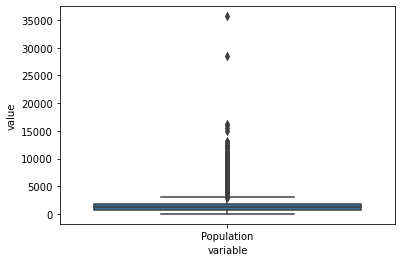

<Figure size 1152x648 with 0 Axes>

In [2]:
corr = calif_df['Population'].corr(calif_df['MedHouseVal'])
print('Correlation \'Population\' to Target: ',corr)
show_boxplot(calif_df, ['Population'])

Оптимизируем параметр Population путем замены на значение медианы массива.

In [3]:
calif_df['Population'] = calif_df['Population'].median()

Разобьем датасет на тренировочную и тестовую выборку, построим модель линейной регрессии, выведем точность.

In [4]:
X = calif_df.loc[:, calif_df.columns != 'MedHouseVal']
Y = calif_df['MedHouseVal']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

linearRegression = LinearRegression()
linearRegression.fit(X_train, Y_train)
print('Score linear regression: ', linearRegression.score(X_test, Y_test))

Score linear regression:  0.6094124655205764


Построим модель дерева решений, выведем точность и визуализируем дерево.

Score decision tree. Depth=3:  0.5094748706644598


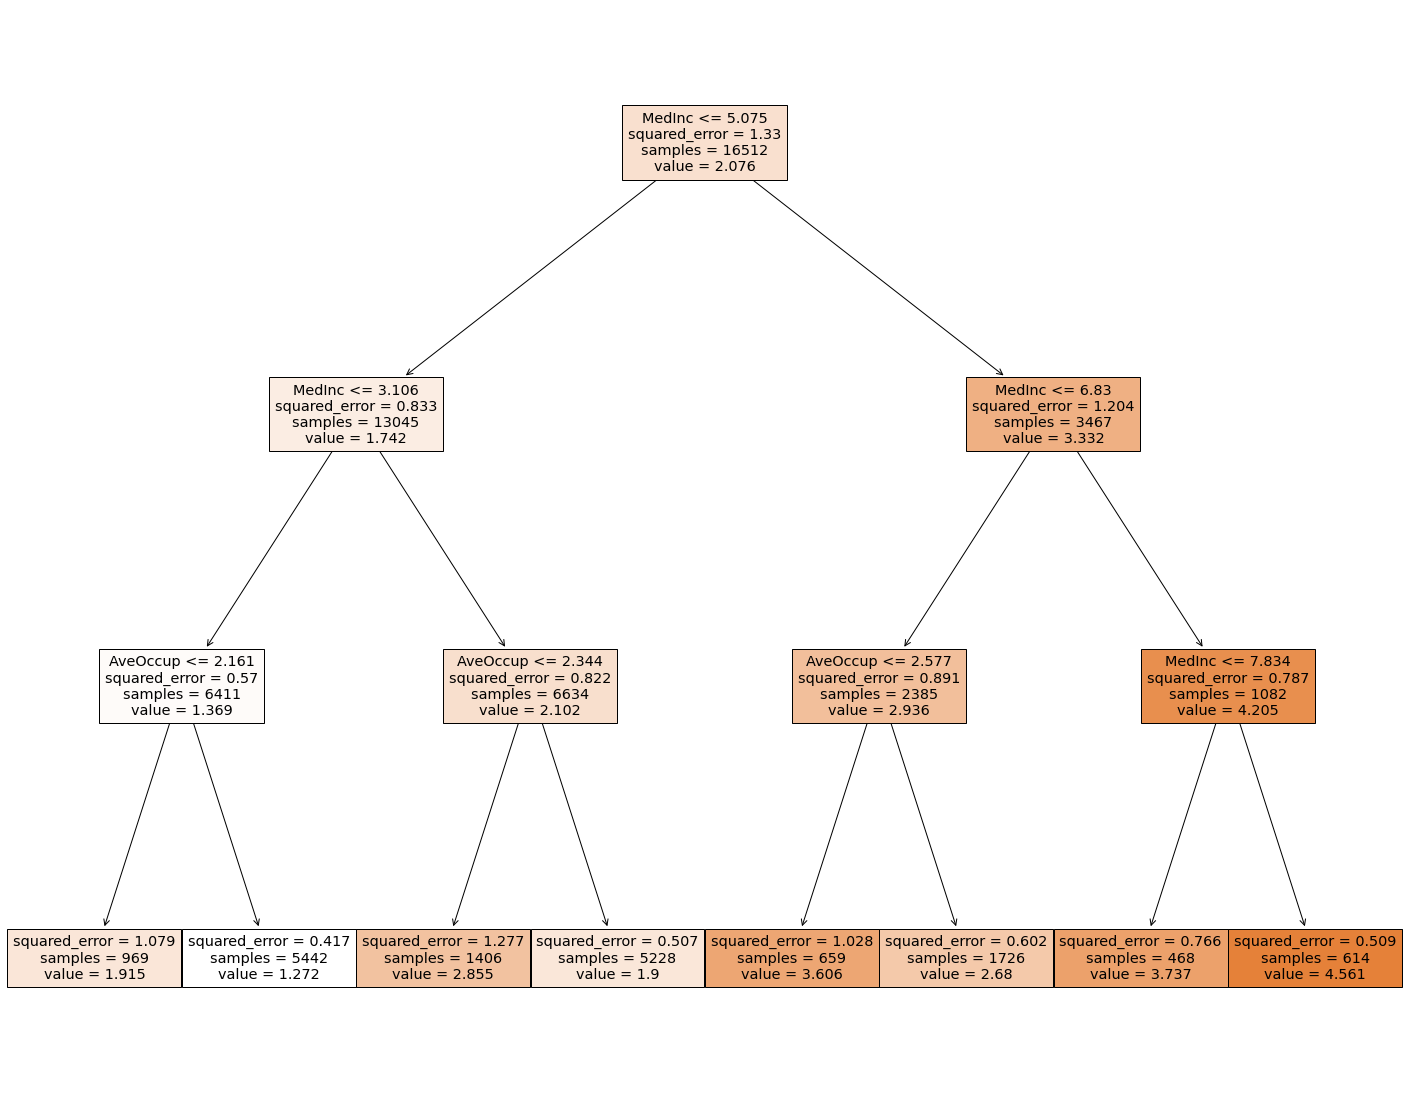

In [5]:
clf = DecisionTreeRegressor(max_depth=3)
clf.fit(X_train, Y_train)
print('Score decision tree. Depth=3: ', clf.score(X_test, Y_test))

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=california_bunch.feature_names,  
                   class_names=california_bunch.target_names,
                   filled=True)

Выберем параметр с наибольшими выбросами и обрежим выборку.

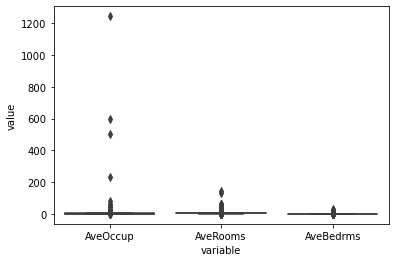

<Figure size 1152x648 with 0 Axes>

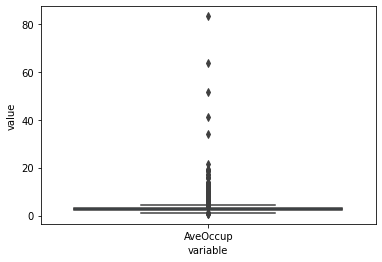

<Figure size 1152x648 with 0 Axes>

In [6]:
show_boxplot(calif_df, columns=['AveOccup','AveRooms','AveBedrms'])
calif_df = calif_df[calif_df['AveOccup']<=200]
show_boxplot(calif_df, columns=['AveOccup'])

Построим модель дерева решений на новой выборке и выведем точность

In [7]:
X = calif_df.loc[:, calif_df.columns != 'MedHouseVal']
Y = calif_df['MedHouseVal']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

clf = DecisionTreeRegressor(max_depth=5)
clf.fit(X_train, Y_train)
print('Score decision tree. Depth=5: ', clf.score(X_test, Y_test))

Score decision tree. Depth=5:  0.6080577324316239


Score linear regression:  0.5965051953441063
Score decision tree. Depth=3:  0.5103939095059159
Score decision tree. Depth=5:  0.6053606120693897

Выведя точность можно увидеть, что деревья могут классифицировать лучше регрессии, если правильно подобрать глубину обучения.
Деревья удобнее воспринимать визуально, это дает им некоторое приимущество, например при работе с заказчиком.

Подберем наилучшие параметры для дерева с помощью gridsearchcv

In [8]:
from sklearn.model_selection import GridSearchCV
parametrs = { 'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

clf = GridSearchCV(DecisionTreeRegressor(), parametrs, cv=5)
clf.fit(X_train, Y_train)
best_params = clf.best_params_
print('Best params for decision tree: ', best_params)
print('Score best params decision tree: ', clf.score(X_test, Y_test))

Best params for decision tree:  {'max_depth': 11, 'min_samples_leaf': 7, 'min_samples_split': 8}
Score best params decision tree:  0.7308512584591269


Получили наилучший результат точности.